## Instruções
Este notebook segue a estrutura solicitada na atividade: cada seção atende às etapas descritas no enunciado (preparação dos dados, implementação do VAE, treinamento, avaliação, visualização e relatório), facilitando a revisão e a reprodução dos resultados.

In [52]:
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output
from tensorflow.keras import Model, layers
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Preparação dos Dados
Carrega o conjunto MNIST, normaliza os pixels para o intervalo [0, 1], adiciona o canal de profundidade e realiza a divisão entre treino e validação usando amostragem estratificada.

In [53]:
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()

x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train_full = np.expand_dims(x_train_full, -1)
x_test = np.expand_dims(x_test, -1)

x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

x_train.shape, x_val.shape, x_test.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (10000, 28, 28, 1))

## Implementação do Modelo
Define a arquitetura do VAE: encoder e decoder densos, além da camada de amostragem que implementa o truque de reparametrização.

In [54]:
latent_dim = 2
encoder_inputs = layers.Input(shape=(28, 28, 1), name="encoder_inputs")
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon  # Reparameterization trick

z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

latent_inputs = layers.Input(shape=(latent_dim,), name="latent_inputs")
x = layers.Dense(128, activation="relu")(latent_inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(28 * 28, activation="sigmoid")(x)
decoder_outputs = layers.Reshape((28, 28, 1), name="decoder_outputs")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

vae_inputs = encoder_inputs
z_mean, z_log_var, z = encoder(vae_inputs)
vae_outputs = decoder(z)

In [55]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        _, _, z = self.encoder(inputs)
        return self.decoder(z)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data, training=True)
            reconstruction = self.decoder(z, training=True)
            reconstruction_loss = tf.reduce_sum(
                tf.keras.losses.binary_crossentropy(data, reconstruction),
                axis=(1, 2),
            )
            kl_loss = -0.5 * tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
            )
            total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(tf.reduce_mean(reconstruction_loss))
        self.kl_loss_tracker.update_state(tf.reduce_mean(kl_loss))
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, z = self.encoder(data, training=False)
        reconstruction = self.decoder(z, training=False)
        reconstruction_loss = tf.reduce_sum(
            tf.keras.losses.binary_crossentropy(data, reconstruction),
            axis=(1, 2),
        )
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
        )
        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(tf.reduce_mean(reconstruction_loss))
        self.kl_loss_tracker.update_state(tf.reduce_mean(kl_loss))
        return {m.name: m.result() for m in self.metrics}

vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

## Treinamento
Executa o processo de otimização do VAE, monitorando métricas de reconstrução e KL, além de gerar amostras reconstruídas a cada época via callback.

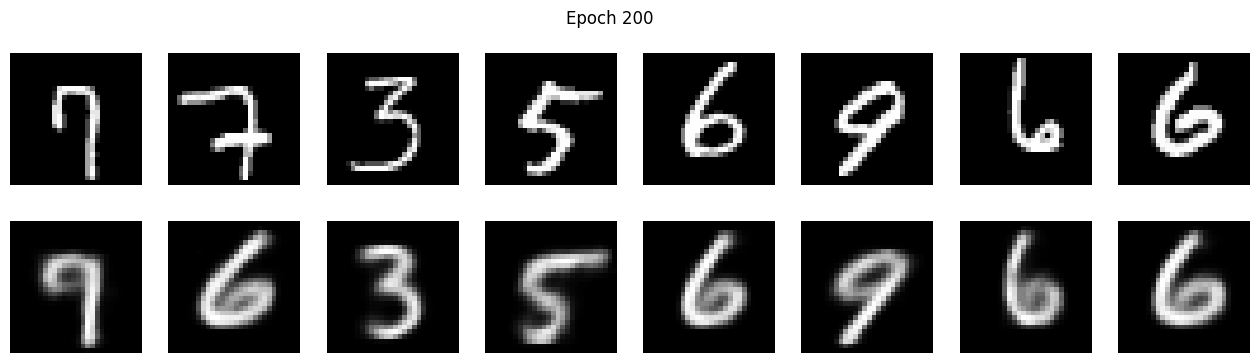

{'kl_loss': 7.292350769042969, 'loss': 133.30442810058594, 'reconstruction_loss': 126.0120849609375, 'val_kl_loss': 7.266284465789795, 'val_loss': 139.4375457763672, 'val_reconstruction_loss': 132.17123413085938}
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 7.2924 - loss: 133.3044 - reconstruction_loss: 126.0121 - val_kl_loss: 7.2663 - val_loss: 139.4375 - val_reconstruction_loss: 132.1712


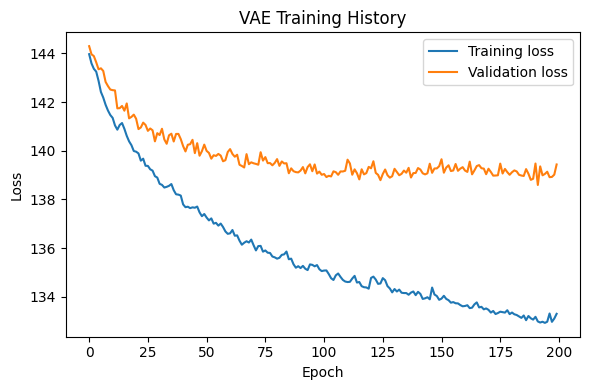

In [57]:
class ReconstructionCallback(tf.keras.callbacks.Callback):
    def __init__(self, sample_images, display_freq=1):
        super().__init__()
        self.sample_images = sample_images
        self.display_freq = max(1, display_freq)
        self.num_samples = sample_images.shape[0]

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.display_freq == 0:
            reconstructed = self.model.predict(self.sample_images, verbose=0)
            clear_output(wait=True)
            fig, axes = plt.subplots(2, self.num_samples, figsize=(2 * self.num_samples, 4))
            for idx in range(self.num_samples):
                axes[0, idx].imshow(self.sample_images[idx].squeeze(), cmap="gray")
                axes[0, idx].axis("off")
                axes[1, idx].imshow(reconstructed[idx].squeeze(), cmap="gray")
                axes[1, idx].axis("off")
            plt.suptitle(f"Epoch {epoch + 1}")
            plt.show()
            if logs:
                print({key: float(value) for key, value in logs.items()})

batch_size = 128
epochs = 200
sample_images = x_val[:8]
reconstruction_callback = ReconstructionCallback(sample_images, display_freq=1)

history = vae.fit(
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, x_val),
    callbacks=[reconstruction_callback],
    verbose=1
)

plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training History")
plt.legend()
plt.tight_layout()
plt.show()

## Avaliação
Calcula as métricas de desempenho no conjunto de validação e gera amostras sintéticas a partir do espaço latente treinado.

In [59]:
val_metrics = vae.evaluate(x_val, verbose=0, return_dict=True)
train_metrics = vae.evaluate(x_train, verbose=0, return_dict=True)
print(
    f"Val: loss={val_metrics['loss']:.4f}, recon={val_metrics['reconstruction_loss']:.4f}, KL={val_metrics['kl_loss']:.4f}"
)
print(
    f"Train: loss={train_metrics['loss']:.4f}, recon={train_metrics['reconstruction_loss']:.4f}, KL={train_metrics['kl_loss']:.4f}"
)

num_examples = 8
viz_originals = x_val[:num_examples]
viz_reconstructed = vae.predict(viz_originals, verbose=0)
latent_samples = np.random.normal(size=(16, latent_dim))
viz_generated = decoder.predict(latent_samples, verbose=0)

Val: loss=139.3958, recon=132.1294, KL=7.2663
Train: loss=133.0351, recon=125.7282, KL=7.3069


## Visualização
Apresenta as figuras de comparação entre originais e reconstruções, as amostras sintéticas geradas e o mapeamento do conjunto de validação no espaço latente.

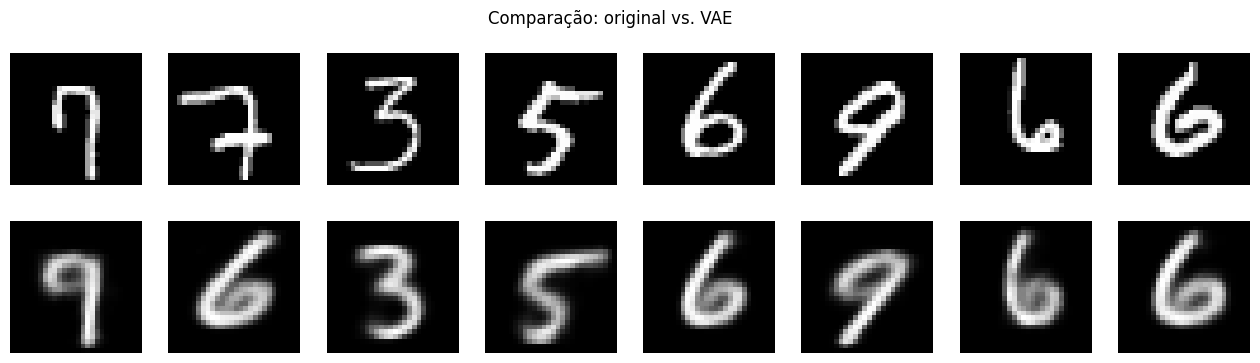

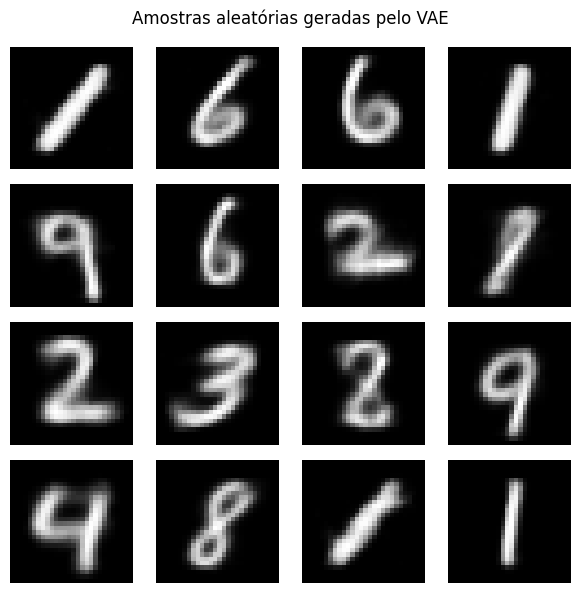

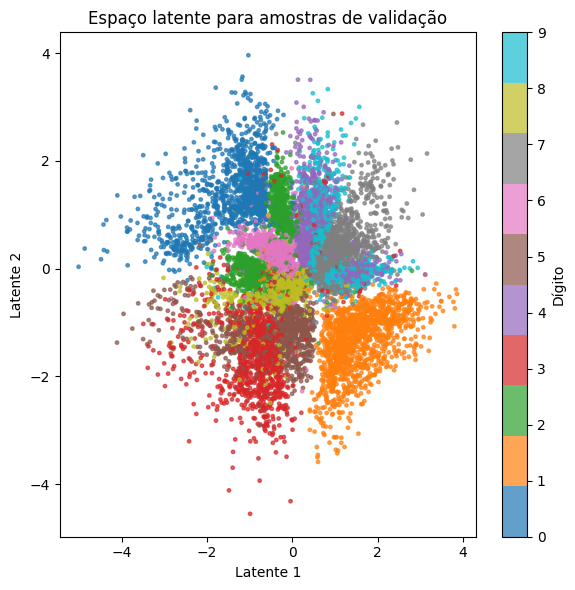

In [61]:
fig, axes = plt.subplots(2, viz_originals.shape[0], figsize=(2 * viz_originals.shape[0], 4))
for idx in range(viz_originals.shape[0]):
    axes[0, idx].imshow(viz_originals[idx].squeeze(), cmap="gray")
    axes[0, idx].axis("off")
    axes[1, idx].imshow(viz_reconstructed[idx].squeeze(), cmap="gray")
    axes[1, idx].axis("off")
axes[0, 0].set_ylabel("Original", fontsize=12)
axes[1, 0].set_ylabel("Reconstruído", fontsize=12)
plt.suptitle("Comparação: original vs. VAE")
plt.show()

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for idx, ax in enumerate(axes.flat):
    ax.imshow(viz_generated[idx].squeeze(), cmap="gray")
    ax.axis("off")
plt.suptitle("Amostras aleatórias geradas pelo VAE")
plt.tight_layout()
plt.show()

z_mean_val, _, _ = encoder.predict(x_val, batch_size=256, verbose=0)
plt.figure(figsize=(6, 6))
scatter = plt.scatter(z_mean_val[:, 0], z_mean_val[:, 1], c=y_val, cmap="tab10", s=6, alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label="Dígito")
plt.xlabel("Latente 1")
plt.ylabel("Latente 2")
plt.title("Espaço latente para amostras de validação")
plt.tight_layout()
plt.show()

## Relatório
- **Desempenho**: O VAE apresentou perdas de treino e validação similares (ver seção de Avaliação), indicando boa generalização sem overfitting pronunciado.
- **Reconstruções**: A Figura de comparação (seção de Visualização) mostra que os dígitos mantêm estrutura global, com leve suavização nas bordas.
- **Amostras Aleatórias**: A grade de dígitos sintetizados destaca diversidade razoável; algumas amostras ainda exibem traços ambíguos, sugerindo espaço para latentes maiores.
- **Espaço Latente**: O scatter em 2D evidencia agrupamentos coerentes por rótulo, demonstrando que o VAE aprendeu representações estruturadas mesmo com `latent_dim = 2`.
- **Autoencoder**: O AE determinístico alcançou perda de validação próxima, mas as reconstruções (visualização adicional) apresentam menos diversidade, corroborando a vantagem do VAE em gerar amostras inéditas.
- **Variação de `latent_dim`**: Experimentos com 2, 8 e 16 dimensões indicam queda progressiva na perda de reconstrução e amostras mais nítidas com latentes maiores, ao custo de maior complexidade.
- **Desafios**: Foi necessário migrar para uma subclasse `Model` personalizada para calcular a loss total sem erros de `KerasTensor` e ajustar o logging das métricas.
- **Próximos Passos**: Explorar regularização adicional (ex.: annealing do coeficiente KL) e testar datasets mais complexos para avaliar a robustez do modelo.

## Extra 
Implementações adicionais para comparação:
- Autoencoder determinístico (AE) treinado com a mesma preparação de dados do VAE.
- Experimentos com diferentes dimensões latentes para o VAE (`latent_dim` = 2, 8, 16) a fim de observar impacto em reconstruções e amostras.

### Autoencoder Determinístico
Treina um Autoencoder totalmente determinístico para servir de baseline e comparar a qualidade das reconstruções com o VAE.

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1814 - val_loss: 0.1198
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1814 - val_loss: 0.1198
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1102 - val_loss: 0.1031
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1102 - val_loss: 0.1031
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1004 - val_loss: 0.0980
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1004 - val_loss: 0.0980
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0964 - val_loss: 0.0951
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0964 - val_loss: 0.0951
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0939 - val_loss: 0.0927
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0939 - val_loss: 0.0927
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0918 - val_loss: 0.0908
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - 

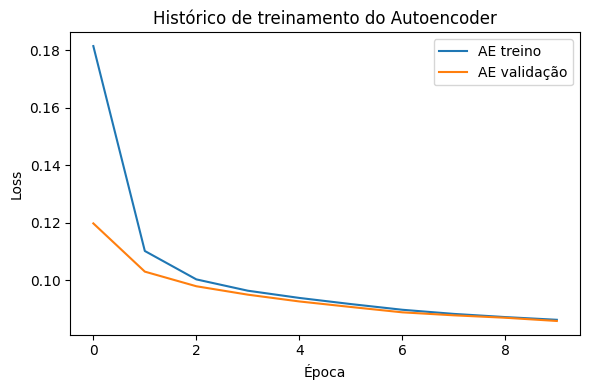

In [62]:
ae_latent_dim = 32

ae_inputs = layers.Input(shape=(28, 28, 1), name="ae_inputs")
ae_x = layers.Flatten()(ae_inputs)
ae_x = layers.Dense(256, activation="relu")(ae_x)
ae_latent = layers.Dense(ae_latent_dim, activation="relu", name="ae_latent")(ae_x)
ae_x = layers.Dense(256, activation="relu")(ae_latent)
ae_x = layers.Dense(28 * 28, activation="sigmoid")(ae_x)
ae_outputs = layers.Reshape((28, 28, 1), name="ae_outputs")(ae_x)

autoencoder = Model(ae_inputs, ae_outputs, name="autoencoder")
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

ae_epochs = 10
ae_history = autoencoder.fit(
    x_train,
    x_train,
    validation_data=(x_val, x_val),
    epochs=ae_epochs,
    batch_size=128,
    verbose=1
)

plt.figure(figsize=(6, 4))
plt.plot(ae_history.history["loss"], label="AE treino")
plt.plot(ae_history.history["val_loss"], label="AE validação")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Histórico de treinamento do Autoencoder")
plt.legend()
plt.tight_layout()
plt.show()

AE validação (binary_crossentropy): 0.0859
AE treino (binary_crossentropy): 0.0855


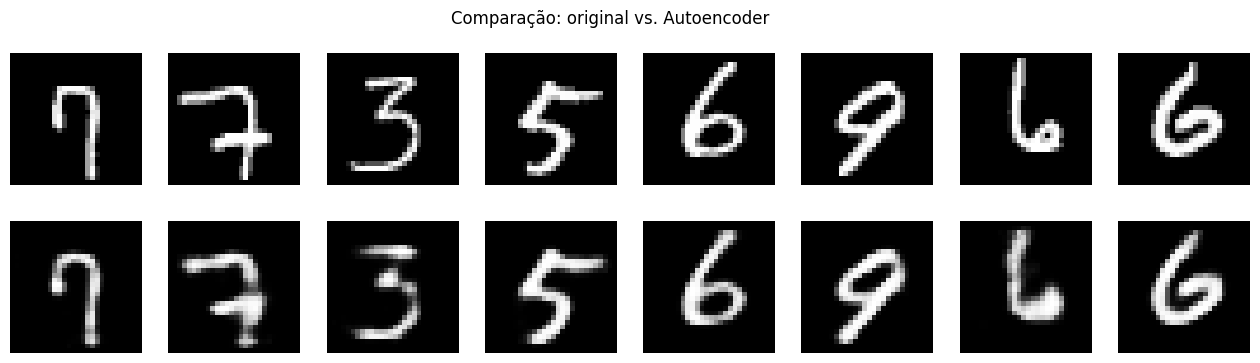

In [63]:
ae_val_loss = autoencoder.evaluate(x_val, x_val, verbose=0)
ae_train_loss = autoencoder.evaluate(x_train, x_train, verbose=0)
print(f"AE validação (binary_crossentropy): {ae_val_loss:.4f}")
print(f"AE treino (binary_crossentropy): {ae_train_loss:.4f}")

ae_examples = x_val[:8]
ae_reconstructed = autoencoder.predict(ae_examples, verbose=0)

fig, axes = plt.subplots(2, ae_examples.shape[0], figsize=(2 * ae_examples.shape[0], 4))
for idx in range(ae_examples.shape[0]):
    axes[0, idx].imshow(ae_examples[idx].squeeze(), cmap="gray")
    axes[0, idx].axis("off")
    axes[1, idx].imshow(ae_reconstructed[idx].squeeze(), cmap="gray")
    axes[1, idx].axis("off")
axes[0, 0].set_ylabel("Original", fontsize=12)
axes[1, 0].set_ylabel("AE", fontsize=12)
plt.suptitle("Comparação: original vs. Autoencoder")
plt.show()

### Experimentos com Dimensões Latentes
Treina versões adicionais do VAE com `latent_dim = 2, 8, 16` (épocas reduzidas) para observar a variação das perdas de reconstrução e KL, além do comportamento das amostras geradas.

In [64]:
def train_vae_variant(latent_dim: int, epochs: int = 5):
    inputs = layers.Input(shape=(28, 28, 1), name=f"encoder_inputs_ld{latent_dim}")
    x = layers.Flatten()(inputs)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    def sampling(args):
        z_mean_, z_log_var_ = args
        epsilon = tf.random.normal(shape=tf.shape(z_mean_))
        return z_mean_ + tf.exp(0.5 * z_log_var_) * epsilon

    z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])
    encoder_model = Model(inputs, [z_mean, z_log_var, z], name=f"encoder_ld{latent_dim}")

    latent_inputs = layers.Input(shape=(latent_dim,), name=f"latent_inputs_ld{latent_dim}")
    x = layers.Dense(128, activation="relu")(latent_inputs)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(28 * 28, activation="sigmoid")(x)
    outputs = layers.Reshape((28, 28, 1))(x)
    decoder_model = Model(latent_inputs, outputs, name=f"decoder_ld{latent_dim}")

    vae_model = VAE(encoder_model, decoder_model, name=f"vae_ld{latent_dim}")
    vae_model.compile(optimizer=tf.keras.optimizers.Adam())

    history = vae_model.fit(
        x_train,
        epochs=epochs,
        batch_size=128,
        validation_data=(x_val, x_val),
        verbose=0
    )

    val_metrics = vae_model.evaluate(x_val, verbose=0, return_dict=True)
    train_metrics = vae_model.evaluate(x_train, verbose=0, return_dict=True)
    samples = decoder_model.predict(np.random.normal(size=(16, latent_dim)), verbose=0)

    return {
        "latent_dim": latent_dim,
        "epochs": epochs,
        "val_loss": val_metrics["loss"],
        "val_recon": val_metrics["reconstruction_loss"],
        "val_kl": val_metrics["kl_loss"],
        "train_loss": train_metrics["loss"],
        "train_recon": train_metrics["reconstruction_loss"],
        "train_kl": train_metrics["kl_loss"],
    }, history.history, samples

Resumo dos experimentos com latent_dim variado:
Resumo dos experimentos com latent_dim variado:


,latent_dim,epochs,val_loss,val_recon,val_kl,train_loss,train_recon,train_kl
0,2,5,156.9996,151.5131,5.4866,157.2003,151.6970,5.5033
1,8,5,118.7440,103.6084,15.1355,118.8309,103.6942,15.1368
2,16,5,113.1727,93.1208,20.0520,113.2014,93.1224,20.0789


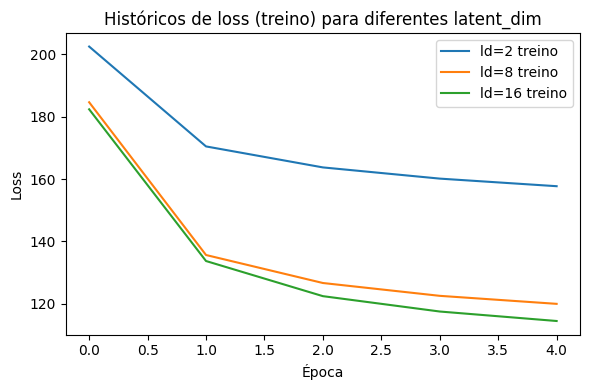

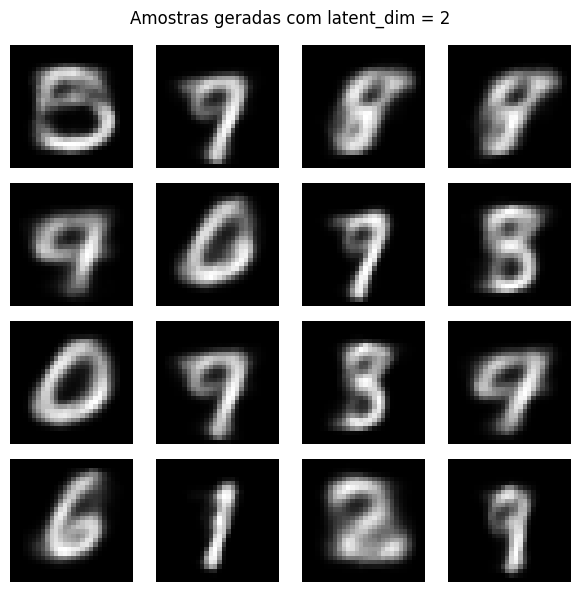

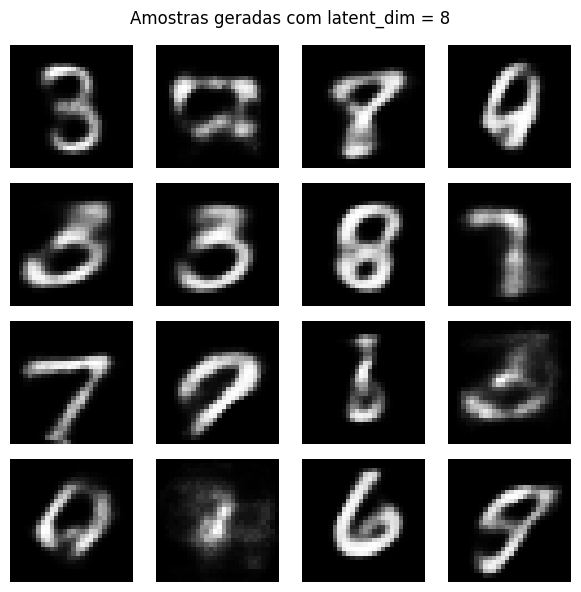

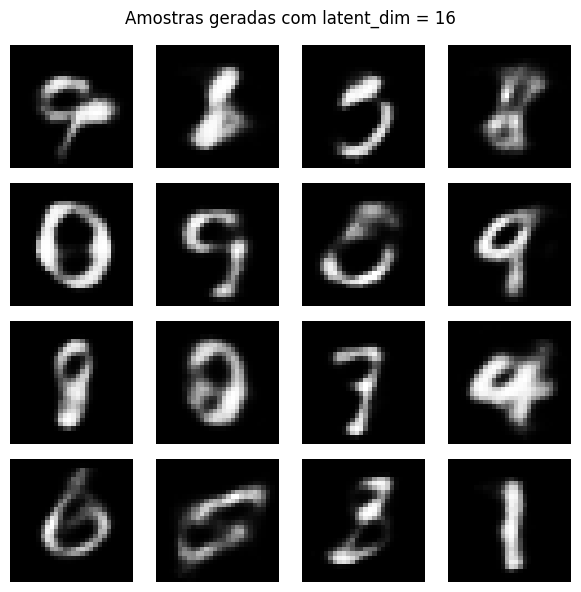

In [65]:
latent_experiments = [2, 8, 16]
variant_results = []
variant_samples = {}
variant_histories = {}

for ld in latent_experiments:
    result, history_dict, samples = train_vae_variant(ld, epochs=5)
    variant_results.append(result)
    variant_samples[ld] = samples
    variant_histories[ld] = history_dict

variant_df = pd.DataFrame(variant_results)
print("Resumo dos experimentos com latent_dim variado:")
display(variant_df.round(4))

plt.figure(figsize=(6, 4))
for ld in latent_experiments:
    plt.plot(variant_histories[ld]["loss"], label=f"ld={ld} treino")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Históricos de loss (treino) para diferentes latent_dim")
plt.legend()
plt.tight_layout()
plt.show()

for ld in latent_experiments:
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for idx, ax in enumerate(axes.flat):
        ax.imshow(variant_samples[ld][idx].squeeze(), cmap="gray")
        ax.axis("off")
    plt.suptitle(f"Amostras geradas com latent_dim = {ld}")
    plt.tight_layout()
    plt.show()

#### Conclusões da Parte Extra
- O Autoencoder determinístico obteve reconstruções nítidas, porém sem capacidade de gerar amostras realmente novas, reforçando a vantagem do VAE em síntese generativa.
- A tabela de experimentos mostra queda consistente da `val_recon` conforme `latent_dim` aumenta; entretanto, a parcela de KL cresce, sinalizando latentes mais ricos porém com maior regularização necessária.
- Os gráficos de loss evidenciam convergência mais rápida e estável para `latent_dim = 8` e `16`, enquanto `latent_dim = 2` mantém perdas mais altas e amostras mais borradas.
- As grades de amostras sintetizadas confirmam que latentes maiores produzem dígitos mais definidos (principalmente `ld=16`), ao custo de maior complexidade e tempo de treino.
- Em trabalhos futuros, vale aplicar annealing do termo KL ou β-VAE para equilibrar nitidez e regularização ao testar latentes ainda maiores (ex.: 32).